# EDA Notebook

## Library

In [1]:
import sys

sys.path.append("..")
sys.path.append("../../inputs")

## Logging

In [2]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

## Load Data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

### Train Data

このデータセットには、何千もの投資案件の実際の履歴データから得られた特徴が含まれています。難読化された指標を予測し、売買の意思決定を行うことが課題です。

このコンペティションは、時系列APIに依存し、モデルが時間を遡ることがないようにするコードコンペティションです。APIを使用するには、評価ページの指示に従います。ノートブックを提出すると、そのノートブックは未見のテストで再実行されます。これは予測コンペでもあり、最終的なプライベートリーダーボードはトレーニング期間終了後に集められたデータを使って決定されるため、パブリックリーダーボードとプライベートリーダーボードの重複はゼロとなります。


In [4]:
%%time

train = pd.read_csv("../../inputs/train.csv")

CPU times: user 2min 24s, sys: 10.6 s, total: 2min 34s
Wall time: 2min 34s


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float64(301), int64(2), object(1)
memory usage: 7.1+ GB


- `row_id`: 行の一意な識別子。
- `time_id`: データが収集された時刻を表すIDコードです。時間IDは順番に並んでいるが、時間ID間の実時間は一定ではなく、最終的なプライベートテストセットではトレーニングセットより**短くなる**可能性が高い。row_id 0_1 と 0_2 のことであれば、その通り、同時に取得されます。 `0~1219` 
- `investment_id`: 投資のIDコードです。すべての投資家がすべての時間帯のIDでデータを持っているわけではありません。investment_idとある投資の対応関係は固定されている。 `0~3773` テストデータでは、`investment_id` はこの範囲を超える場合があります。
- `target`: 目的変数
- `[f_0:f_299]`: 市場データから生成された匿名化された特徴量。

In [6]:
train

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,1219_3768,1219,3768,0.033600,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,1219_3769,1219,3769,-0.223264,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,1219_3770,1219,3770,-0.559415,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,1219_3772,1219,3772,0.009599,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


In [62]:
train.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109231e-02,1.637029e-03,-1.257751e-02,8.514525e-03,-2.003680e-02,-5.416390e-03,-3.034038e-03,1.934292e-03,...,1.257389e-02,8.997587e-04,-6.509002e-03,2.850204e-03,-4.732863e-03,-2.773725e-02,-1.517806e-03,-7.058300e-03,-4.216856e-03,-4.319445e-03
std,3.560434e+02,1.083616e+03,9.197057e-01,1.081097e+00,1.032447e+00,1.031786e+00,9.630771e-01,9.943869e-01,1.105940e+00,1.068882e+00,...,1.085783e+00,1.114992e+00,1.071597e+00,1.103297e+00,1.145119e+00,9.608897e-01,1.141631e+00,1.109445e+00,1.052312e+00,1.010046e+00
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


### Example Test Data

投稿時にAPIがどのような形状・形式のデータをあなたのノートブックに配信するかを示すために提供されるランダムデータです。

In [7]:
test = pd.read_csv("../../inputs/example_test.csv")

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Columns: 303 entries, row_id to f_299
dtypes: float64(300), int64(2), object(1)
memory usage: 21.4+ KB


In [9]:
test

,row_id,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1220_1,1220,1,0.874944,0.457875,0.962572,0.372061,0.004509,0.971304,0.097477,...,0.514031,0.828523,0.437697,0.810764,0.693963,0.186403,0.569144,0.120386,0.419603,0.936966
1,1220_2,1220,2,0.554862,0.445478,0.714034,0.891988,0.703331,0.264478,0.600636,...,0.620919,0.301540,0.687464,0.400168,0.908198,0.272901,0.222430,0.748324,0.858802,0.362829
2,1221_0,1221,0,0.175070,0.918464,0.044379,0.505868,0.037160,0.169001,0.211365,...,0.397710,0.789382,0.238078,0.254068,0.795084,0.491928,0.376725,0.079489,0.995041,0.482283
3,1221_1,1221,1,0.355239,0.689773,0.452643,0.134863,0.794958,0.837197,0.036773,...,0.893571,0.322879,0.674692,0.114160,0.818483,0.287065,0.710537,0.550434,0.899869,0.928997
4,1221_2,1221,2,0.912778,0.462684,0.454067,0.491009,0.050547,0.250051,0.686295,...,0.031662,0.703427,0.861476,0.897927,0.659051,0.356148,0.375990,0.209798,0.175153,0.727160
5,1222_0,1222,0,0.678116,0.158996,0.058148,0.253677,0.984982,0.323493,0.307990,...,0.439604,0.487491,0.080697,0.539750,0.246645,0.435054,0.436709,0.315042,0.133657,0.731483
6,1222_1,1222,1,0.769912,0.060028,0.676047,0.853550,0.411155,0.747515,0.649063,...,0.419152,0.659254,0.198072,0.655397,0.428209,0.769999,0.960219,0.734675,0.028576,0.320976
7,1222_2,1222,2,0.738876,0.980038,0.696796,0.591012,0.882052,0.311484,0.729229,...,0.341144,0.758328,0.010728,0.276859,0.979913,0.486605,0.670140,0.515824,0.580929,0.139308
8,1223_0,1223,0,0.281445,0.571472,0.986828,0.021403,0.789577,0.005765,0.409379,...,0.357828,0.000019,0.504530,0.169174,0.216349,0.503643,0.052721,0.795965,0.909602,0.291668


### Example Sample Submission

API の一般公開されたコピーが正しいデータの形と形式を提供するように提供される提出ファイルの例です。

In [10]:
sample_sub = pd.read_csv("../../inputs/example_sample_submission.csv")

In [11]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   9 non-null      object
 1   time_id  9 non-null      int64 
 2   target   9 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 344.0+ bytes


In [12]:
sample_sub

,row_id,time_id,target
0,1220_1,1220,0
1,1220_2,1220,0
2,1221_0,1221,0
3,1221_1,1221,0
4,1221_2,1221,0
5,1222_0,1222,0
6,1222_1,1222,0
7,1222_2,1222,0
8,1223_0,1223,0


### Time Series API

時系列APIの詳細 - APIはバッチごとにデータを提供し、バッチごとに1つの`time_id`を持つ。

- テストセットには約100万行が含まれると予想される
- APIは、初期化後におよそ0.25GBのメモリを必要とします。初期化ステップ(env.iter_test())では、それ以上のメモリが必要になります。
- また、APIの実行時間は、データの読み込みと配信に15分未満を予定しています。

時系列APIは呼び出すたびに、ある time_id のデータを返す

In [13]:
sys.path.append("../../inputs")

import ubiquant

env = ubiquant.make_env()  # initialize the environment
iter_test = env.iter_test()  # an iterator which loops over the test set and sample submission
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    print(f"=========== turn: {n} ==========")
    print("===== test_df info =====")
    print(test_df[["row_id", "investment_id"]])
    print("===== sample_prediction_df info =====")
    print(sample_prediction_df)
    
    sample_prediction_df["target"] = 0  # make your predictions here
    env.predict(sample_prediction_df)  # register your predictions
    
    # break

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
=========== turn: 0 ==========
===== test_df info =====
   row_id  investment_id
0  1220_1              1
1  1220_2              2
===== sample_prediction_df info =====
   row_id  target
0  1220_1     0.0
1  1220_2     0.0
=========== turn: 1 ==========
===== test_df info =====
   row_id  investment_id
0  1221_0              0
1  1221_1              1
2  1221_2              2
===== sample_prediction_df info =====
   row_id  target
0  1221_0     0.0
1  1221_1     0.0
2  1221_2     0.0
=========== turn: 2 ==========
===== test_df info =====
   row_id  investment_id
0  1222_0              0
1  1222_1              1
2  1222_2              2
===== sample_prediction_df info =====
   row_id  target
0  1222_0     0.0
1  1222_1     0.0
2  1222_2     0.0
=========== turn: 3 ==========
===== test_df info =====
   row_id  investment_id
0  1223_0              0
===== sample_p

### Evaluation

提出物は、各タイムIDのピアソン相関係数の平均値で評価されます。


Pearsonの(積率)相関係数とは
https://www.st-hakky-blog.com/entry/2018/01/30/004659

以下の式で表され、-1～1の値の間で値が変化します。

![image](https://user-images.githubusercontent.com/1638500/150124817-59c1f5ad-acd0-424e-9f39-56f6ccda2784.png)

変数間の直線関係の強度を知りたいときにこの相関係数を使用します。「データにおいて、xとyのばらつきぐあいが完全に一致していたら、相関係数が1になる」ことがわかります。

また、ピアソンの相関係数では、変数が正規分布に従っていることを仮定しています。なので、正規分布に従っていると仮定できるデータがあったとして、そのデータの直線関係の強度を知りたい時、これは使えます。



### Timeline

このコンペティションは、アクティブなトレーニング期間と、実際の市場データに対してモデルを実行する第2期間を設けた予測コンペティションです。

最終提出期限以降、選択されたノートブックに対して実行されるデータの更新を反映して、リーダーボードが定期的に更新されます。更新はおよそ2週間おきに行われる予定です。

- 学習期間締め切り: 4/19 9:00
- 評価期間終了: 7/18

## Emulator

学習データを Time Series API 経由で取得するためのエミュレータ

In [83]:
small_train = train[train["investment_id"] < 10]

In [84]:
small_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7694 entries, 0 to 3137979
Columns: 304 entries, row_id to f_299
dtypes: float64(301), int64(2), object(1)
memory usage: 17.9+ MB


In [86]:
small_train[:20]

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
5,0_9,0,9,1.505904,0.608855,1.369305,-0.761515,0.865860,-0.359269,-1.835762,...,0.333684,-1.095620,-0.335999,0.819155,-1.060166,-0.343812,-1.087009,0.077862,0.142943,-0.055550
2272,1_1,1,1,-0.917045,0.373575,0.296349,0.019102,-0.031842,-0.222027,-0.199950,...,0.235071,-1.081652,0.645607,0.581035,0.839101,-0.362388,1.229239,-1.301037,-0.391490,0.330331
2273,1_2,1,2,-0.472108,1.126988,-0.444550,0.830523,-0.646731,-0.200634,1.901568,...,0.167517,-1.081652,-0.751495,0.581035,0.839101,-0.440931,0.027711,-1.119905,-0.885063,-0.663321
2274,1_6,1,6,-0.147971,0.095686,0.913764,0.464530,-0.636130,0.068600,-1.343771,...,-0.341965,0.924511,-0.345185,0.581035,0.839101,-0.250618,1.229239,0.527778,-0.145435,0.249976
2275,1_7,1,7,-0.372692,-1.720719,-0.444550,1.855611,-0.635220,-0.579904,-0.491992,...,1.254035,0.924511,-0.212120,0.581035,0.839101,-0.641496,-1.173816,-0.897268,1.358109,-0.798216


In [81]:
from src.time_series_api import TimeSeriesAPI

In [91]:
iter_test = TimeSeriesAPI(small_train[:20])

for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    print(f"=========== turn: {n} ==========")
    print("===== test_df info =====")
    print(test_df[["row_id", "investment_id"]])
    print("===== sample_prediction_df info =====")
    print(sample_prediction_df)
    
    sample_prediction_df["target"] = test_df["f_0"]  # make your predictions here
    iter_test.predict(sample_prediction_df)  # register your predictions
    
    # break

=========== turn: 0 ==========
===== test_df info =====
  row_id  investment_id
0    0_1              1
1    0_2              2
2    0_6              6
3    0_7              7
4    0_8              8
5    0_9              9
===== sample_prediction_df info =====
  row_id  target
0    0_1     0.0
1    0_2     0.0
2    0_6     0.0
3    0_7     0.0
4    0_8     0.0
5    0_9     0.0
=========== turn: 1 ==========
===== test_df info =====
   row_id  investment_id
6     1_1              1
7     1_2              2
8     1_6              6
9     1_7              7
10    1_8              8
11    1_9              9
===== sample_prediction_df info =====
   row_id  target
6     1_1     0.0
7     1_2     0.0
8     1_6     0.0
9     1_7     0.0
10    1_8     0.0
11    1_9     0.0
=========== turn: 2 ==========
===== test_df info =====
   row_id  investment_id
12    2_1              1
13    2_2              2
14    2_6              6
15    2_7              7
16    2_8              8
17    2_9         

In [93]:
iter_test.score.avg

0.271267280039024

In [95]:
iter_test.rs

[0.4741251603216194, 0.09597969833883568, -0.4850357385043591, 1.0]

In [94]:
iter_test.probs

[0.34210266343707185, 0.856472539900929, 0.3295010655572086, 1.0]

## EDA

/opt/miniconda3/envs/py37-all-in-one/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

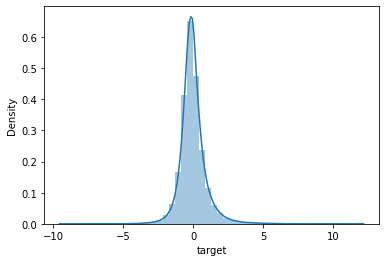

In [14]:
# 目的変数の分布
sns.distplot(train["target"], hist=True)

((array([-5.05022204, -4.87809103, -4.78523997, ...,  4.78523997,
          4.87809103,  5.05022204]),
  array([-9.419646, -9.017216, -8.759128, ..., 11.280593, 11.506284,
         12.038613])),
 (0.8808422612232555, -0.02109230840828774, 0.9577420216551489))

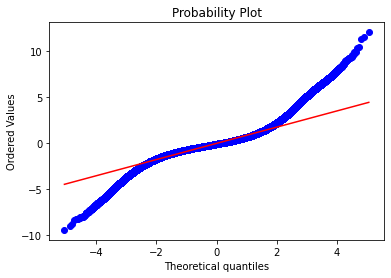

In [15]:
# 正規分布との一致度
stats.probplot(train["target"], dist="norm", plot=plt)

### 目的変数を時系列でプロット

In [16]:
investment_ids = list(set(train["investment_id"]))
len(investment_ids)

3579

<Figure size 432x288 with 0 Axes>

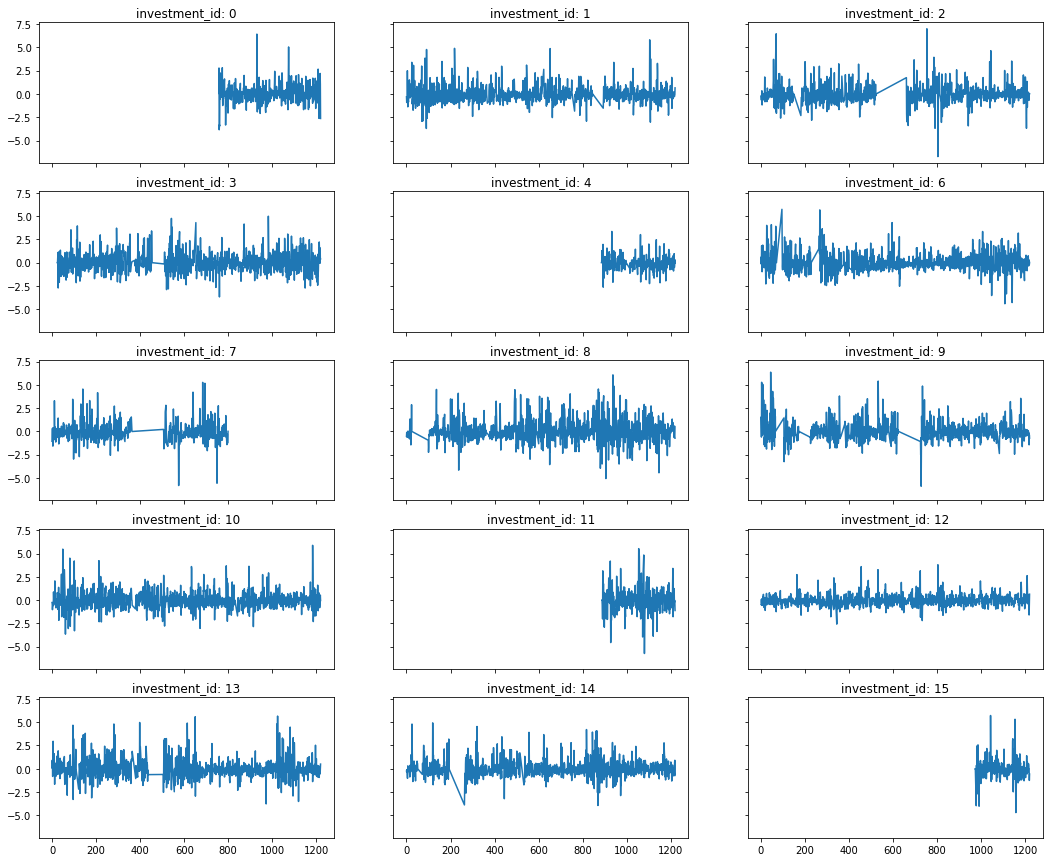

In [17]:
# 目的変数を時系列でプロット
plt.clf()  # flush previous drawings
fig, axes = plt.subplots(5, 3, figsize=(6 * 3, 3 * 5), sharex = "all", sharey = "all")

for i, investment_id in enumerate(investment_ids[:15]):
    axes[i // 3, i % 3].set_title(f"investment_id: {investment_id}")
    df = train[train["investment_id"] == investment_id]
    axes[i // 3, i % 3].plot(df["time_id"], df["target"])

### 特徴量を時系列でプロット

In [18]:
time_ids = list(set(train["time_id"]))
len(time_ids)

1211

In [19]:
feature_cols = df.columns[4:]
feature_cols

Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=300)

<Figure size 432x288 with 0 Axes>

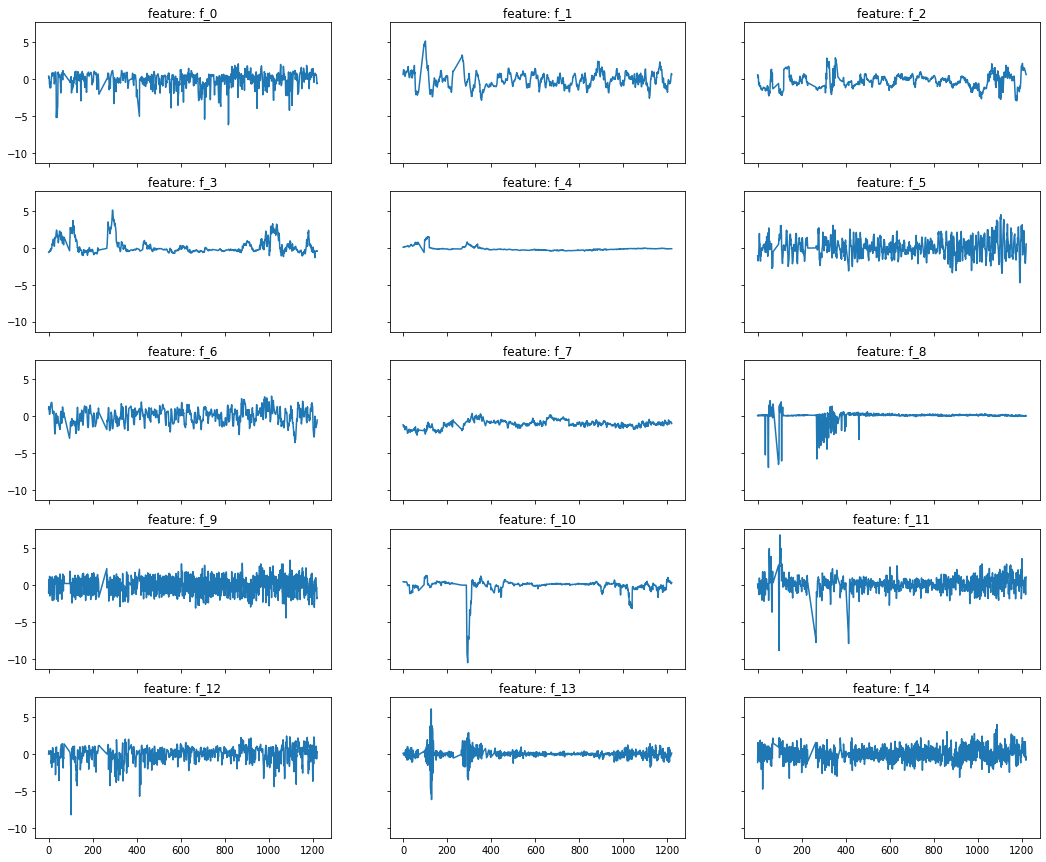

In [20]:
# 特徴量を時系列でプロット
investment_id = 6

plt.clf()  # flush previous drawings
fig, axes = plt.subplots(5, 3, figsize=(6 * 3, 3 * 5), sharex = "all", sharey = "all")

for i, col_name in enumerate(feature_cols[:15]):
    axes[i // 3, i % 3].set_title(f"feature: {col_name}")
    df = train[train["investment_id"] == investment_id]
    axes[i // 3, i % 3].plot(df["time_id"], df[col_name])

### 目的変数と特徴量との相関

In [21]:
df = train[train["investment_id"] == investment_id]
cols = df.columns[3:]
cols

Index(['target', 'f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=301)

In [22]:
df_corr = df[cols].corr()
df_corr

,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
target,1.000000,0.054150,0.096177,-0.000627,-0.048652,-0.009470,0.060600,-0.010275,-0.073473,0.008534,...,-0.049234,-0.016429,0.047261,0.007965,-0.011512,-0.015410,-0.039679,-0.078883,-0.070950,-0.009861
f_0,0.054150,1.000000,-0.067595,0.095368,-0.047300,-0.017492,-0.035726,-0.010155,-0.031490,0.002125,...,0.039448,-0.043727,-0.041227,-0.035188,-0.043616,-0.009057,0.056475,-0.007512,-0.068631,-0.012407
f_1,0.096177,-0.067595,1.000000,-0.464171,0.271121,0.246041,-0.004593,0.183306,-0.273580,-0.020163,...,-0.313958,-0.017257,0.053264,0.203877,0.022742,0.215692,-0.001564,0.129641,0.289164,0.126249
f_2,-0.000627,0.095368,-0.464171,1.000000,-0.538895,-0.310208,0.047018,-0.214491,0.212661,-0.012569,...,0.256812,-0.014948,-0.033908,-0.233264,0.018541,-0.266978,-0.065215,-0.029804,-0.538583,-0.118674
f_3,-0.048652,-0.047300,0.271121,-0.538895,1.000000,0.640148,0.008107,-0.024722,-0.208532,-0.140103,...,-0.112223,-0.063394,0.266486,0.067890,-0.039686,0.502625,0.016909,0.001062,0.392987,0.574741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f_295,-0.015410,-0.009057,0.215692,-0.266978,0.502625,0.579693,0.027946,-0.086986,-0.163238,-0.209436,...,-0.190432,0.055285,0.142481,0.008769,0.069606,1.000000,0.059363,0.139520,0.169301,0.405802
f_296,-0.039679,0.056475,-0.001564,-0.065215,0.016909,0.023050,0.003802,0.011271,0.032675,-0.033435,...,-0.191593,0.133743,-0.109657,0.029696,0.032521,0.059363,1.000000,0.096495,0.032586,-0.007744
f_297,-0.078883,-0.007512,0.129641,-0.029804,0.001062,-0.009885,-0.210001,-0.041941,-0.006693,-0.114791,...,-0.323629,0.359300,-0.178310,-0.062093,0.285848,0.139520,0.096495,1.000000,0.012189,-0.090635
f_298,-0.070950,-0.068631,0.289164,-0.538583,0.392987,0.172080,-0.084471,0.168942,-0.119357,-0.039494,...,-0.094621,0.030874,0.038964,0.170331,0.040920,0.169301,0.032586,0.012189,1.000000,0.123631


<AxesSubplot:>

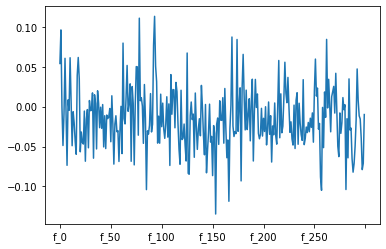

In [23]:
# 目的変数と、特徴量との相関
df_corr["target"][1:].plot()

In [24]:
#fig = plt.subplots(figsize=(18, 15))
#sns.heatmap(df_corr)

<Figure size 432x288 with 0 Axes>

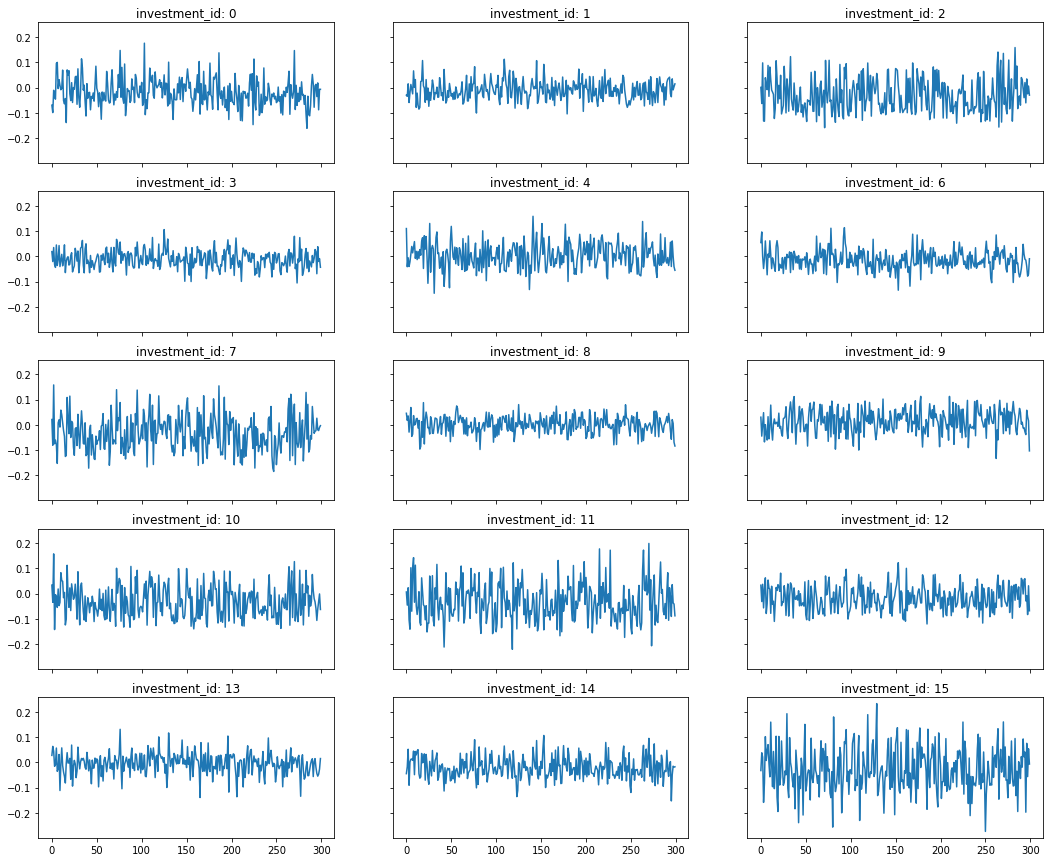

In [25]:
# 目的変数と、特徴量との相関
plt.clf()  # flush previous drawings
fig, axes = plt.subplots(5, 3, figsize=(6 * 3, 3 * 5), sharex = "all", sharey = "all")

for i, investment_id in enumerate(investment_ids[:15]):
    axes[i // 3, i % 3].set_title(f"investment_id: {investment_id}")
    df = train[train["investment_id"] == investment_id]
    cols = df.columns[3:]
    df_corr = df[cols].corr()
    axes[i // 3, i % 3].plot(range(300), df_corr["target"][1:])

In [44]:
%%time

# 目的変数と特徴量との相関関係をすべての投資IDについて明らかにする
df_corrs = pd.DataFrame(np.zeros((len(investment_ids), 300)))

for i, investment_id in enumerate(investment_ids):
    df = train[train["investment_id"] == investment_id]
    cols = df.columns[3:]
    df_corr = df[cols].corr()
    df_corrs.iloc[i, :] = df_corr["target"][1:].reset_index(drop=True)

CPU times: user 7min 2s, sys: 215 ms, total: 7min 3s
Wall time: 7min 3s


In [45]:
df_corrs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.069747,-0.099194,-0.010849,-0.036269,-0.046010,0.095802,0.099446,-0.004102,0.031181,0.008504,...,0.051852,0.014415,-0.078046,0.006780,0.012726,-0.035782,0.018325,-0.088206,-0.006756,-0.006993
1,-0.030216,-0.034828,0.014673,-0.059378,-0.020318,0.012239,-0.006548,-0.024969,0.065989,0.000640,...,0.020418,0.032887,0.036784,0.041038,-0.025030,-0.036490,0.034373,-0.009360,0.003534,0.014509
2,0.000648,-0.063274,0.097653,-0.132196,-0.133478,0.038798,0.011589,-0.008431,0.087495,-0.034798,...,0.039474,0.031169,-0.006568,-0.040121,0.019689,-0.060649,0.034085,-0.024973,0.006013,-0.030031
3,0.018361,-0.021023,0.034518,-0.032298,-0.044174,0.044639,-0.036603,-0.013769,0.042342,-0.040861,...,0.002825,-0.025349,-0.007983,0.026594,0.018112,-0.069254,0.037913,-0.020666,-0.009597,-0.043672
4,0.109624,-0.041570,-0.006077,-0.040687,-0.022020,0.010393,0.038817,0.013272,0.035404,0.057958,...,-0.027326,-0.005123,-0.036480,-0.012978,0.055380,-0.040630,0.060473,0.000305,-0.041690,-0.055624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,-0.001072,-0.070706,0.070379,-0.043751,-0.020925,0.067096,-0.027791,0.030605,0.092629,-0.046451,...,0.041298,-0.031079,0.001749,-0.037275,-0.045137,0.007997,0.017488,-0.102802,-0.045021,0.017847
3575,0.013151,0.104981,0.036230,0.054456,0.003808,-0.017109,0.027526,0.031876,0.010961,0.006033,...,0.020863,-0.031778,-0.007716,-0.044432,-0.011009,-0.109059,-0.009060,-0.043156,-0.000694,0.058064
3576,-0.000211,-0.021419,0.018798,-0.096810,-0.031323,0.012289,0.007373,-0.025633,0.021556,-0.033398,...,0.013291,0.030427,-0.010107,-0.042729,0.023927,-0.009690,0.008354,-0.056614,-0.052146,0.001289
3577,0.000596,-0.040242,0.086480,-0.082081,-0.000890,0.039199,-0.031233,0.001697,0.051809,-0.055807,...,0.103843,-0.042500,-0.025884,-0.019287,-0.073632,-0.128088,-0.017824,-0.135523,0.001566,-0.054435


In [48]:
df_corrs_stats = df_corrs.describe()
df_corrs_stats

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,3578.000000,3578.000000,3573.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,...,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3577.000000,3578.000000
mean,0.008888,-0.020892,0.037560,-0.047390,-0.035624,0.029947,-0.013146,0.004406,0.030337,-0.020575,...,0.025933,-0.000033,0.004581,0.000845,-0.014748,-0.038491,-0.005134,-0.043799,-0.015250,-0.022568
std,0.046560,0.050393,0.048783,0.058734,0.057694,0.049463,0.048125,0.051425,0.061366,0.043247,...,0.048832,0.043612,0.053285,0.045154,0.043168,0.066221,0.048446,0.049149,0.046532,0.051779
min,-0.579740,-0.388270,-0.331902,-0.485036,-1.000000,-0.515967,-0.992985,-0.452308,-0.563349,-0.694725,...,-0.500000,-0.712712,-1.000000,-0.590371,-0.497503,-1.000000,-0.868481,-0.788101,-0.679454,-1.000000
25%,-0.015628,-0.048143,0.007735,-0.081484,-0.063854,0.003886,-0.036895,-0.023484,-0.004238,-0.045064,...,-0.002096,-0.023799,-0.025881,-0.022520,-0.039497,-0.073542,-0.028819,-0.071646,-0.040868,-0.049433
50%,0.009868,-0.019360,0.037405,-0.046273,-0.031272,0.030056,-0.013102,0.003120,0.029134,-0.021623,...,0.024769,-0.000629,0.005893,0.002087,-0.014483,-0.035116,-0.005388,-0.043580,-0.015430,-0.021877
75%,0.034916,0.006801,0.066988,-0.012333,-0.001275,0.056652,0.012037,0.028403,0.062311,0.002079,...,0.053860,0.023016,0.035009,0.025350,0.009537,0.001152,0.018709,-0.016609,0.011090,0.005722
max,0.423814,0.734891,0.293827,0.702267,0.701955,0.731231,0.602520,0.677186,0.743957,0.380818,...,0.548413,0.371243,0.445370,0.451679,0.283423,0.573944,0.520940,0.420906,0.634305,0.307909


In [53]:
df_corrs_stats.loc["mean", :].sort_values()

231   -0.065966
286   -0.064382
212   -0.062549
15    -0.060308
250   -0.059919
         ...   
169    0.047026
72     0.047842
76     0.049154
119    0.053344
270    0.055172
Name: mean, Length: 300, dtype: float64

In [54]:
df_corrs_stats.loc["max", :].sort_values()

100    0.221283
67     0.221813
128    0.226429
57     0.234882
139    0.236676
         ...   
165    1.000000
183    1.000000
126    1.000000
214    1.000000
55     1.000000
Name: max, Length: 300, dtype: float64

In [55]:
df_corrs_stats.loc["min", :].sort_values()

83    -1.000000
260   -1.000000
130   -1.000000
299   -1.000000
235   -1.000000
         ...   
63    -0.283037
268   -0.282593
124   -0.278376
287   -0.228446
275   -0.214300
Name: min, Length: 300, dtype: float64

<AxesSubplot:>

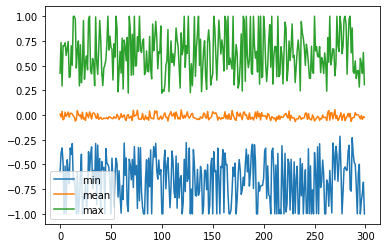

In [57]:
df_corrs_stats.T[["min", "mean", "max"]].plot()

In [58]:
# 相関係数の最大値が 1.0 の特徴量
df_corrs_stats.T[df_corrs_stats.T["max"] == 1.0]

,count,mean,std,min,25%,50%,75%,max
14,3578.0,-0.019965,0.049621,-0.637998,-0.045737,-0.020712,0.004889,1.0
29,3578.0,0.031937,0.055102,-0.570479,0.001156,0.029552,0.060198,1.0
68,3578.0,-0.031907,0.052653,-0.445383,-0.061033,-0.031912,-0.003366,1.0
73,3578.0,-0.012004,0.052010,-0.319219,-0.037873,-0.011201,0.014915,1.0
78,3578.0,-0.043850,0.058287,-0.867088,-0.075363,-0.044802,-0.014617,1.0
151,3578.0,0.021938,0.049094,-0.370549,-0.004899,0.020893,0.047586,1.0
162,3578.0,0.033049,0.051508,-0.383163,0.005221,0.031488,0.060567,1.0
170,3578.0,0.000543,0.045453,-0.526313,-0.023585,-0.000896,0.022160,1.0
190,3578.0,-0.049676,0.054903,-0.743282,-0.079468,-0.048139,-0.018026,1.0
195,3578.0,-0.017017,0.051056,-0.680371,-0.043063,-0.017509,0.008701,1.0


<AxesSubplot:>

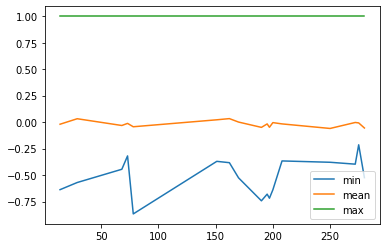

In [59]:
df_corrs_stats.T[df_corrs_stats.T["max"] == 1.0][["min", "mean", "max"]].plot()

In [60]:
# 相関係数の最小値が -1.0 の特徴量
df_corrs_stats.T[df_corrs_stats.T["min"] == -1.0]

,count,mean,std,min,25%,50%,75%,max
4,3578.0,-0.035624,0.057694,-1.0,-0.063854,-0.031272,-0.001275,0.701955
18,3578.0,0.012010,0.049013,-1.0,-0.011583,0.012898,0.037120,0.750351
44,3578.0,-0.032438,0.052145,-1.0,-0.062095,-0.032716,-0.003913,0.504500
90,3578.0,-0.035132,0.048286,-1.0,-0.061516,-0.035625,-0.008690,0.366181
101,3578.0,-0.027087,0.054272,-1.0,-0.055514,-0.024777,0.004971,0.253517
128,3578.0,-0.016387,0.053381,-1.0,-0.044410,-0.015433,0.013566,0.226429
154,3578.0,0.001679,0.047080,-1.0,-0.021690,0.002162,0.026368,0.353180
173,3578.0,-0.053592,0.057102,-1.0,-0.085835,-0.051311,-0.019368,0.713447
207,3578.0,-0.055174,0.054235,-1.0,-0.084618,-0.052667,-0.023816,0.484634
220,3578.0,-0.007483,0.051007,-1.0,-0.035928,-0.007489,0.019901,0.632472


<AxesSubplot:>

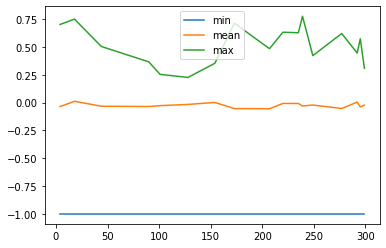

In [61]:
df_corrs_stats.T[df_corrs_stats.T["min"] == -1.0][["min", "mean", "max"]].plot()

In [63]:
# TODO: 相関係数が 1.0 や -1.0 の特徴量の様子を見てみる

## 勉強



- https://qiita.com/blog_UKI/items/09fab7baecd677819895



